# import stuff

In [2]:
%load_ext autoreload
%autoreload 2

# import python stuff
import matplotlib.pyplot as plt
import numpy as np

import scipy
import scipy.special as spe
from scipy import optimize
from scipy.stats import poisson
from qutip import *
import iminuit
import time
import multiprocessing as mp
from platform import python_version
import os

# import my functions
from functionsSqueeze import *
from functions_SpinPhonon import *

# import existing Paula funcitons
from PyModules.analyse_eios import eios_sb
from PyModules.analyse_eios import eios_analyse
from PyModules.analyse_eios import eios_data

print("python version:", python_version())
print("number of CPU's:", mp.cpu_count())

python version: 3.6.9
number of CPU's: 8


# Poisson Fits for two ions

## define poisson fit functions (equivalent funcitons to the ones for one ion in eios_analyse)

In [82]:
# make a function to generate a random number of a two-poissonian distribution
def rand_4Poisson(mu_U, mu_D, alpha=0, P_D1=0.5, P_D2=0.5, sup = 1):
    """generates a random count, taken two bright ions, each emitting light following a two poissonian distribution
    parameters:
        mu_U: low count rate (when the ion is in its dark, spin up state)
        mu_D: high count rate (when the ion is in its bright, spin down state)
        alpha: counts, by which the counts of the two bright states differ
        P_D1/P_D2: probability of ion one/two to be in the down (bright) state
        sup: factor, by which the count rate of ion 1 is suppressed"""
    rd1 = np.random.rand()
    rd2 = np.random.rand()
    
    ret = 0
    # counts by ion 1
    if P_D1 > rd1:
        ret += sup*np.random.poisson(mu_D - 0.5*alpha)
    else:
        ret += sup*np.random.poisson(mu_U)
    
    # counts by ion 2
    if P_D2 > rd2:
        ret += np.random.poisson(mu_D + 0.5*alpha)
    else:
        ret += np.random.poisson(mu_U)

    return ret

In [83]:
def mLL_2I(data, mu_dd, mu_du, mu_uu, p_dd, p_du, p_uu):
    """returns the negative log likelihood functin of a two-poissonian distribution with:
        means mu1 and mu2
        weights (1-p_up) and fit_p_up
        data: an array filled with random numbers from the two-poissonian distribution
    """
    
    # make sure that p_up \in [0, 1]
#     if not (0<= p_up <= 1):
#         p_up = np.max([p_up, 0])
#         p_up = np.min([p_up, 1])

    return -np.sum(np.log(p_dd/(p_dd+p_du+p_uu)*poisson.pmf(data, mu_dd) + p_du/(p_dd+p_du+p_uu)*poisson.pmf(data, mu_du)
                         + p_uu/(p_dd+p_du+p_uu)*poisson.pmf(data, mu_uu)))

In [84]:
def fit_poisson_hist_2I(hist, lowcount=1., highcount=16.):
    """fits a sum of two two-poissonian distributions (see mLL) to a sample hist
    """
    # if hist is a list of histograms, merge them into one hist
    if len(np.shape(hist)) > 1:
        hist = np.append([],hist)

    def func(mu_dd, mu_du, mu_uu, p_dd, p_du, p_uu):
        return mLL_2I(np.array(hist), mu_dd, mu_du, mu_uu, p_dd, p_du, p_uu)

    m = iminuit.Minuit(func, mu_dd = highcount, mu_du = 0.5*highcount, mu_uu = lowcount, p_dd = 0.3, p_du = 0.4, p_uu = 0.3,
                # initial stepsize
               error_mu_dd = 1., error_mu_du = 0.5, error_mu_uu = 0.1, error_p_dd = 0.05, error_p_du = 0.05, error_p_uu = 0.05,
               errordef = 0.5,
                # bounds
               limit_mu_dd = (0., 50), limit_mu_du = (0., 50), limit_mu_uu = (0., 50.), limit_p_dd=(0.,1.), limit_p_du=(0.,1.), limit_p_uu=(0.,1.))
    m.migrad()
    
    # make sure the probabilities add up to 1
    norm = m.values[3] + m.values[4] + m.values[5]
    
    res = {
        'x': [m.values[0], m.values[1], m.values[2], m.values[3]/norm, m.values[4]/norm, m.values[5]/norm],
        'x_err': [m.errors[0], m.errors[1], m.errors[2], m.errors[3]/norm, m.errors[4]/norm, m.errors[5]/norm]
    }
    return res

In [85]:
def helper_fit_hist_2I(hist, fit_mu_dd, fit_mu_du, fit_mu_uu):
#     """fits the weights of a two-poissonian distribution (with fixed means fit_mu1, fit_mu2) to the sample given in hists
#     returns the weight and its error
#     """
    if len(hist) == 0: # make sure the hist is not empty
        raise ValueError('empty histogram')
    else:
        # make a helper function to throw into minuit
        func = lambda p_dd, p_du, p_uu: mLL_2I(np.array(hist), fit_mu_dd, fit_mu_du, fit_mu_uu, p_dd, p_du, p_uu)
        
        # make a minuit object
        m = iminuit.Minuit(func, p_dd = 0.3, p_du = 0.4, p_uu = 0.3,
                           error_p_dd = 0.05, error_p_du = 0.05, error_p_uu = 0.05, errordef = 0.5,
                           limit_p_dd=(0.,1.), limit_p_du=(0.,1.), limit_p_uu=(0.,1.))

        
        # minimize the funciton
        m.migrad()
        # return the parameter and error (not sure about second summand, taken from original function in eios)
        
        # make sure the probabilities add up to 1
        norm = m.values[0] + m.values[1] + m.values[2]
        norm_err = np.sqrt(m.errors[0]**2 + m.errors[1]**2 + m.errors[2]**2)
        
#         err0 = np.sqrt(m.errors[0]**2 + m.values[0]**2/norm**2 * norm_err**2)/norm
#         err1 = np.sqrt(m.errors[1]**2 + m.values[1]**2/norm**2 * norm_err**2)/norm
#         err2 = np.sqrt(m.errors[2]**2 + m.values[2]**2/norm**2 * norm_err**2)/norm
        err0 = m.errors[0]/norm
        err1 = m.errors[1]/norm
        err2 = m.errors[2]/norm
        
        err0 = np.min([err0, np.sqrt(err1**2+err2**2)])
        err1 = np.min([err1, np.sqrt(err2**2+err0**2)])
        err2 = np.min([err2, np.sqrt(err0**2+err1**2)])
        
        return m.values[0]/norm, m.values[1]/norm, m.values[2]/norm, err0, err1, err2

    

# my function for all hist fits (needs pre fit), from rob
def fit_hist_2I(hists, pre_fit, parallel = True):
    t1 = time.time()
#     """fits the weights of a two-poissonian distribution to the samples given in hists
#     parameters:
#         hists: array of arrays, each one a sample of a two-poissonian distribution
#             should a sample be empty, the corresponding y, y_err are set to nan
#         pre_fit: fit result from a fit on all histograms in hists combined
#             (the expectation values mu1, mu2 are taken and fixed in the fits done here)
#             (scipy optimize result, from fit_poisson_hist or fit_poisson_hist_rob)
#         parallel: bool, default False, if parallel computing should be used (better performance, if the mp module works)
#         remove_nan: bool, default True, sets if nans (from empty lists in hists) should be removed in the output
#     returns y, y_err
#         y: a list of weights for the two-poissonian distribution (weight corresponding to mu2, mu2 > mu1)
#         y_err: errors of the weights
#     """
    
    # take variables from prefit
    fit_mu_1, fit_mu_2, fit_mu_3,_,_,_ = pre_fit['x']
    [fit_mu_uu, fit_mu_du, fit_mu_dd] = np.sort([fit_mu_1, fit_mu_2, fit_mu_3])
#     print(fit_mu_uu, fit_mu_du, fit_mu_dd)

    if parallel:
        args = [(hist, fit_mu_dd, fit_mu_du, fit_mu_uu) for hist in hists]
        pool = mp.Pool(mp.cpu_count())
        res_y = pool.starmap(helper_fit_hist_2I, args)
        time.sleep(0.01)
        pool.close()
    else:
        res_y = []
        for hist in hists:
            res_y.append(helper_fit_hist_2I(hist, fit_mu_dd, fit_mu_du, fit_mu_uu))

    # unpack results
    y_dd, y_du, y_uu = [i[0] for i in res_y], [i[1] for i in res_y], [i[2] for i in res_y]
    y_err_dd, y_err_du, y_err_uu = [i[3] for i in res_y], [i[4] for i in res_y], [i[5] for i in res_y]

    # print("fit hists:", np.round(time.time()-t1, 3))
    return y_dd, y_du, y_uu, y_err_dd, y_err_du, y_err_uu

In [86]:
def plot_hist_res_2I(hist, res):
    xx = np.linspace(0, 30, 31)
    mu_dd, mu_du, mu_uu = res['x'][0], res['x'][1], res['x'][2]
    p_dd, p_du, p_uu = res['x'][3], res['x'][4], res['x'][5]
    
    y = p_dd*poisson.pmf(xx, mu_dd) + p_du*poisson.pmf(xx, mu_du) + p_uu*poisson.pmf(xx, mu_uu)
#     y = [(res['x'][2]+res['x'][3])*poisson.pmf(i, res['x'][0]) + (2-res['x'][2]-res['x'][3])*poisson.pmf(i, res['x'][1]) for i in xx]
    
    plt.hist(hist, bins=range(30), rwidth=0.8, align='left', density=True)
    plt.plot(xx, y/np.sum(y))
    plt.show()

## do the fitting

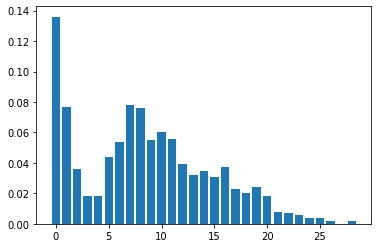

In [87]:
# check the function for my photon counts simulation funcion

hist = [rand_4Poisson(0.3, 8, 2, 0.5, 0.5) for i in range(1000)]

plt.hist(hist, bins=range(30), rwidth=0.8, align='left', density=True)
plt.show()

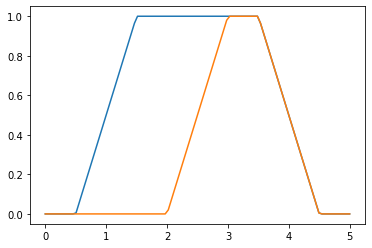

In [88]:
times = np.linspace(-0, 5, 100)

# define a simple ramp funciton
def rmp(t):
    if t <= 0:
        return 0
    elif 0<t<=1:
        return t
    else:
        return 1

Ps1 = np.array([rmp(t-0.5)-rmp(t-3.5) for t in times])
Ps2 = np.array([rmp(t - 2)-rmp(t-3.5) for t in times])

plt.plot(times, Ps1)
plt.plot(times, Ps2)
plt.show()

# simulate data
hists = []
for i, t in enumerate(times):
    hists.append([rand_4Poisson(0.5, 8, 2, Ps1[i], Ps2[i]) for j in range(500)])

In [89]:
# do the prefit to determine the three count levels (with all histograms)

t1 = time.time()
prefit = fit_poisson_hist_2I(hists, 0.5, 10)
print("processing time:", np.round( time.time()-t1, 4))

processing time: 2.0845


In [90]:
# do the fits to determine the population of (down, down) and (down, up) = (up, down) and (up, up)

t1 = time.time()
y_dd, y_du, y_uu, y_err_dd, y_err_du, y_err_uu = fit_hist_2I(hists, prefit, parallel = True)
print("processing time:", np.round( time.time()-t1, 4))

processing time: 0.5572


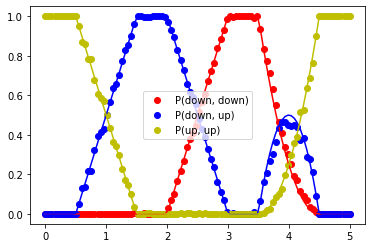

In [91]:
# plt.errorbar(times, y_dd, y_err_dd, fmt = 'ro', label='P(down, down)')
# plt.errorbar(times, y_du, y_err_du, fmt = 'bo', label='P(down, down)')
# plt.errorbar(times, y_uu, y_err_uu, fmt = 'yo', label='P(down, down)')

# fit results
plt.plot(times, y_dd, 'ro', label='P(down, down)')
plt.plot(times, y_du, 'bo', label='P(down, up)')
plt.plot(times, y_uu, 'yo', label='P(up, up)')

# expectation
plt.plot(times, Ps1*Ps2, 'r-') # both down
plt.plot(times, (1-Ps1)*Ps2 + Ps1*(1-Ps2), 'b-') # one down one up
plt.plot(times, (1-Ps1)*(1-Ps2), 'y-') # both up

plt.legend()
plt.show()

This plot shows the results of the fit routine to get the population levels P(down, down), P(up, up) and P(down, up)=P(up, down).<br/>
The dots show the fitted results, and the lines the expectation (e.g. the initial values for the data simulation). It was assumed that the simulated histogram can be fitted on a three-poissonian-distribution, but the data was simulated using a four-poissonian-distribution, with expectation values for the (down, up) state slightly different to the expectation value for the (up, down) state.

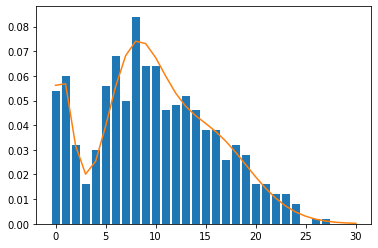

In [61]:
# plot one histogram with the fit
ii = 76
sort_mu = np.sort(prefit['x'][:3])
res = {'x': [sort_mu[2], sort_mu[1], sort_mu[0], y_dd[ii], y_du[ii], y_uu[ii]]}
plot_hist_res_2I(hists[ii], res)

In [77]:
prefit['x'][:3]

[8.256920719449452, 15.677566315867645, 0.6405757276684654]